# Обучение моделей в Pytorch

In [12]:
import os
import random
from os.path import join as pjoin
from shutil import rmtree

import albumentations
import numpy as np
import torch
from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2
from dataset import CustomDataset
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from train import (
    CheckpointSaver,
    IoUMetric,
    MulticlassCrossEntropyLoss,
    MulticlassDiceLoss,
    load_checkpoint,
    train,
)
from unet import UNet, count_model_params

In [13]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)


seed_everything(42, torch_deterministic=False)

## Аугментации

In [14]:
IMAGE_SIZE = 256
transforms = albumentations.Compose(
    [
        albumentations.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        ToTensorV2(),
    ]
)

## Dataset

In [15]:
train_dataset = CustomDataset(root_dir="C:/Segmentation",transforms = transforms)
val_dataset = CustomDataset(root_dir="C:/Segmentation",transforms = transforms)
len(train_dataset)


52

In [16]:
image, target = train_dataset[5]
image


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [17]:
target


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [18]:
image.shape

torch.Size([3, 256, 256])

In [19]:
target.shape

torch.Size([1, 256, 256])

## Accelerator

In [20]:
accelerator = Accelerator(cpu=False, mixed_precision="fp16")

## Обучаем модель

In [21]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_WORKERS = 2
EPOCH_NUM = 20
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

model = UNet(in_channels=3, out_channels=1)

loss_fn = MulticlassDiceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=5, gamma=0.8
)
metric_fn = loss_fn

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="DICE",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=True,
)

In [23]:
# !pip install tensorboard
# tensorboard_logger = None

os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

In [24]:
# акселерируем
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

In [25]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------
Epoch 0/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.03384
Epoch train metric: 0.03384


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.03982
Epoch validation metric: 0.03982
Best epoch DICE value is 0.0398 on 0 epoch
------------------------------
Epoch 1/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.02525
Epoch train metric: 0.02525


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.03226
Epoch validation metric: 0.03226
Best epoch DICE value is 0.0323 on 1 epoch
------------------------------
Epoch 2/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.02314
Epoch train metric: 0.02314


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.02693
Epoch validation metric: 0.02693
Best epoch DICE value is 0.0269 on 2 epoch
------------------------------
Epoch 3/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.02170
Epoch train metric: 0.02170


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.02247
Epoch validation metric: 0.02247
Best epoch DICE value is 0.0225 on 3 epoch
------------------------------
Epoch 4/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.02054
Epoch train metric: 0.02054


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.02504
Epoch validation metric: 0.02504
Best epoch DICE value is 0.0225 on 3 epoch
------------------------------
Epoch 5/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.02047
Epoch train metric: 0.02047


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01828
Epoch validation metric: 0.01828
Best epoch DICE value is 0.0183 on 5 epoch
------------------------------
Epoch 6/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.02001
Epoch train metric: 0.02001


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.02030
Epoch validation metric: 0.02030
Best epoch DICE value is 0.0183 on 5 epoch
------------------------------
Epoch 7/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01900
Epoch train metric: 0.01900


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01984
Epoch validation metric: 0.01984
Best epoch DICE value is 0.0183 on 5 epoch
------------------------------
Epoch 8/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01828
Epoch train metric: 0.01828


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01947
Epoch validation metric: 0.01947
Best epoch DICE value is 0.0183 on 5 epoch
------------------------------
Epoch 9/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01792
Epoch train metric: 0.01792


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01830
Epoch validation metric: 0.01830
Best epoch DICE value is 0.0183 on 5 epoch
------------------------------
Epoch 10/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01723
Epoch train metric: 0.01723


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01931
Epoch validation metric: 0.01931
Best epoch DICE value is 0.0183 on 5 epoch
------------------------------
Epoch 11/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01694
Epoch train metric: 0.01694


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.02187
Epoch validation metric: 0.02187
Best epoch DICE value is 0.0183 on 5 epoch
------------------------------
Epoch 12/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01719
Epoch train metric: 0.01719


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01910
Epoch validation metric: 0.01910
Best epoch DICE value is 0.0183 on 5 epoch
------------------------------
Epoch 13/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01639
Epoch train metric: 0.01639


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01738
Epoch validation metric: 0.01738
Best epoch DICE value is 0.0174 on 13 epoch
------------------------------
Epoch 14/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01672
Epoch train metric: 0.01672


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.02288
Epoch validation metric: 0.02288
Best epoch DICE value is 0.0174 on 13 epoch
------------------------------
Epoch 15/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01677
Epoch train metric: 0.01677


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01781
Epoch validation metric: 0.01781
Best epoch DICE value is 0.0174 on 13 epoch
------------------------------
Epoch 16/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01635
Epoch train metric: 0.01635


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.02373
Epoch validation metric: 0.02373
Best epoch DICE value is 0.0174 on 13 epoch
------------------------------
Epoch 17/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01614
Epoch train metric: 0.01614


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01959
Epoch validation metric: 0.01959
Best epoch DICE value is 0.0174 on 13 epoch
------------------------------
Epoch 18/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01636
Epoch train metric: 0.01636


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01665
Epoch validation metric: 0.01665
Best epoch DICE value is 0.0166 on 18 epoch
------------------------------
Epoch 19/20


Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch train loss: 0.01604
Epoch train metric: 0.01604


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch validation loss: 0.01948
Epoch validation metric: 0.01948
Best epoch DICE value is 0.0166 on 18 epoch


## Загрузим и протестируем обученную модель

In [27]:
model = UNet(in_channels=3, out_channels=1)
model = load_checkpoint(
    model=model, load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt")
)
model = model.to(DEVICE)
model.eval()

UNet(
  (in_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): _Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3)

torch.Size([3, 256, 256])

In [33]:
model(image.unsqueeze(0).to(DEVICE))[0].shape

torch.Size([2, 256, 256])

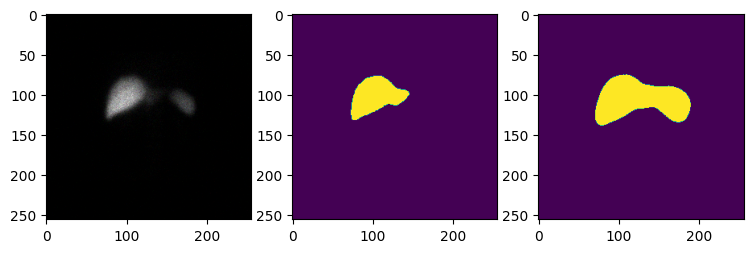

In [40]:
sample_idx = 1
image, target = train_dataset[sample_idx]
thresold = 0.54
preds = F.sigmoid(model(image.unsqueeze(0).to(DEVICE))).squeeze(0)
binary_preds = (preds > thresold)
fig, ax = plt.subplots(1, 3, figsize=(9, 18))
ax[0].imshow(image.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[1].imshow(target.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[2].imshow(binary_preds.cpu().numpy());